In [106]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
import math

In [125]:
df=pd.read_csv("processed_tapes.csv",parse_dates=['date'],index_col='date')
df=df.drop("Unnamed: 0",axis=1)
df=df.dropna()
df=df.sort_values(by='date')
df
# df['date'] = pd.to_datetime(df['date'])

,max_price,min_price,open_price,close_price
date,,,,
2025-01-02,303.0,243.0,267.0,288.0
2025-01-03,317.0,270.0,281.0,291.0
2025-01-06,346.0,276.0,278.0,327.0
2025-01-07,388.0,317.0,336.0,369.0
2025-01-08,374.0,303.0,365.0,311.0
...,...,...,...,...
2025-06-25,114.0,93.0,96.0,104.0
2025-06-26,114.0,94.0,113.0,111.0
2025-06-27,113.0,93.0,106.0,111.0


In [126]:
values=df.values
values=values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.6690141 , 0.66079295, 0.63837636, 0.6996337 ],
       [0.71830976, 0.7797357 , 0.6900369 , 0.71062267],
       [0.82042253, 0.80616736, 0.67896676, 0.8424908 ],
       [0.96830976, 0.9867841 , 0.8929889 , 0.99633694],
       [0.919014  , 0.9251101 , 1.        , 0.78388274],
       [0.89084506, 0.9118943 , 0.8191881 , 0.7875458 ],
       [0.7852112 , 0.80616736, 0.8376384 , 0.67399263],
       [0.84507036, 0.7929516 , 0.67896676, 0.9120879 ],
       [0.8661971 , 0.92951536, 0.9335793 , 0.93406594],
       [0.8661971 , 0.8634361 , 0.9667896 , 0.72893775],
       [0.73239434, 0.73568285, 0.74907744, 0.64835167],
       [0.7359154 , 0.75770926, 0.6937269 , 0.8205128 ],
       [0.919014  , 0.9251101 , 0.7712177 , 0.992674  ],
       [1.        , 0.9779736 , 0.9667896 , 0.8021978 ],
       [0.7922535 , 0.814978  , 0.86715865, 0.7252747 ],
       [0.6725352 , 0.753304  , 0.67896676, 0.6849817 ],
       [0.7007042 , 0.7621145 , 0.67896676, 0.68131864],
       [0.93309855, 0.7929516 ,

In [127]:
#定义series_to_supervised()函数
#将时间序列转换为监督学习问题
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [128]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5,6]],axis=1,inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
1,0.669014,0.660793,0.638376,0.699634,0.710623
2,0.718310,0.779736,0.690037,0.710623,0.842491
3,0.820423,0.806167,0.678967,0.842491,0.996337
4,0.968310,0.986784,0.892989,0.996337,0.783883
5,0.919014,0.925110,1.000000,0.783883,0.787546
...,...,...,...,...,...
120,0.000000,0.000000,0.062731,0.047619,0.025641
121,0.003521,0.000000,0.007380,0.025641,0.051282
122,0.003521,0.004405,0.070111,0.051282,0.051282
123,0.000000,0.000000,0.044280,0.051282,0.047619


In [148]:
# 划分训练集和测试集
values = reframed.values
train = np.concatenate([values[:50, :],values[75:,:]])
test = values[50:75, :]
# 划分训练集和测试集的输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#转化为三维数据
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(99, 1, 4) (99,)
(25, 1, 4) (25,)


In [149]:
test_X

array([[[0.3028169 , 0.35242292, 0.3394834 , 0.34432235]],

       [[0.31338027, 0.35242292, 0.35424355, 0.33333334]],

       [[0.38028166, 0.36563876, 0.36531368, 0.41758242]],

       [[0.38732395, 0.41409692, 0.40590408, 0.36996338]],

       [[0.33802816, 0.30837002, 0.3911439 , 0.2930403 ]],

       [[0.24999997, 0.24669603, 0.302583  , 0.21978024]],

       [[0.2147887 , 0.23348019, 0.2398524 , 0.25641027]],

       [[0.1971831 , 0.16740087, 0.2619926 , 0.16849819]],

       [[0.1338028 , 0.14977977, 0.21033213, 0.13186812]],

       [[0.15140846, 0.15418503, 0.19188192, 0.19413921]],

       [[0.14436617, 0.16740087, 0.21402213, 0.1831502 ]],

       [[0.16197184, 0.18061677, 0.2177122 , 0.19413921]],

       [[0.15492955, 0.15859029, 0.202952  , 0.1794872 ]],

       [[0.1338028 , 0.14537445, 0.19188192, 0.1758242 ]],

       [[0.16549292, 0.14977977, 0.12177122, 0.21611723]],

       [[0.18309858, 0.20264319, 0.17712179, 0.22710624]],

       [[0.20070425, 0.18942735, 0.24723

Epoch 1/50


D:\zzyAnaconda\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


7/7 - 2s - 234ms/step - loss: 0.3723 - val_loss: 0.1857
Epoch 2/50
7/7 - 0s - 8ms/step - loss: 0.3389 - val_loss: 0.1585
Epoch 3/50
7/7 - 0s - 9ms/step - loss: 0.3103 - val_loss: 0.1326
Epoch 4/50
7/7 - 0s - 9ms/step - loss: 0.2852 - val_loss: 0.1105
Epoch 5/50
7/7 - 0s - 9ms/step - loss: 0.2641 - val_loss: 0.0904
Epoch 6/50
7/7 - 0s - 9ms/step - loss: 0.2441 - val_loss: 0.0719
Epoch 7/50
7/7 - 0s - 9ms/step - loss: 0.2214 - val_loss: 0.0549
Epoch 8/50
7/7 - 0s - 9ms/step - loss: 0.2038 - val_loss: 0.0422
Epoch 9/50
7/7 - 0s - 8ms/step - loss: 0.1755 - val_loss: 0.0351
Epoch 10/50
7/7 - 0s - 9ms/step - loss: 0.1594 - val_loss: 0.0351
Epoch 11/50
7/7 - 0s - 9ms/step - loss: 0.1365 - val_loss: 0.0379
Epoch 12/50
7/7 - 0s - 9ms/step - loss: 0.1185 - val_loss: 0.0412
Epoch 13/50
7/7 - 0s - 9ms/step - loss: 0.1108 - val_loss: 0.0429
Epoch 14/50
7/7 - 0s - 9ms/step - loss: 0.0991 - val_loss: 0.0435
Epoch 15/50
7/7 - 0s - 9ms/step - loss: 0.0900 - val_loss: 0.0435
Epoch 16/50
7/7 - 0s - 9ms/s

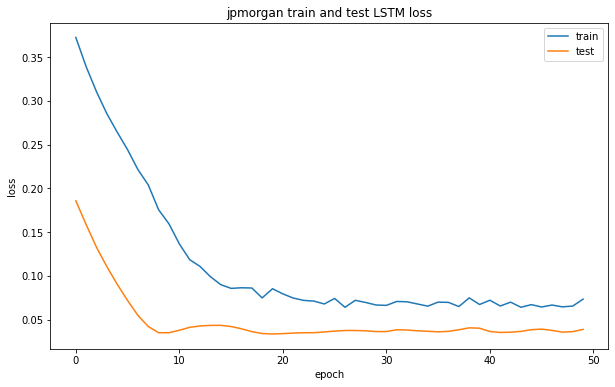

In [150]:
# 搭建LSTM模型
model = Sequential()
model.add(LSTM(32, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1,activation='relu'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=16, validation_data=(test_X, test_y), verbose=2,shuffle=False)

# 绘制损失图
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('jpmorgan train and test LSTM loss', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [151]:
#模型预测收益率
y_predict = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


In [152]:
# invert scaling for forecast
#将预测结果按比例反归一化
inv_y_test = np.concatenate((test_X[:, :3],y_predict), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]

# invert scaling for actual
#将真实结果按比例反归一化
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X[:, :3],test_y), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]
print('反归一化后的预测结果：',inv_y_predict)
print('反归一化后的真实结果：',inv_y)

反归一化后的预测结果： [179.77852 180.21777 191.8364  193.51622 177.509   159.19586 156.33554
 146.07959 136.8331  141.60724 142.27235 144.88506 141.48608 138.90598
 140.31174 147.70142 150.09451 144.91992 152.30904 141.01913 136.12553
 142.24509 137.02025 137.5816  140.64983]
反归一化后的真实结果： [188. 211. 198. 177. 157. 167. 143. 133. 150. 147. 150. 146. 145. 156.
 159. 155. 152. 163. 143. 142. 157. 139. 143. 142. 160.]


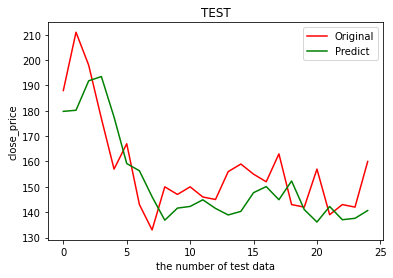

In [153]:
plt.plot(inv_y,color='red',label='Original')
plt.plot(inv_y_predict,color='green',label='Predict')
plt.xlabel('the number of test data')
plt.ylabel('close_price')
plt.title('TEST')
plt.legend()
plt.show()

In [154]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#回归评价指标
# calculate MSE 均方误差
mse=mean_squared_error(inv_y,inv_y_predict)
# calculate RMSE 均方根误差
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
#calculate MAE 平均绝对误差
mae=mean_absolute_error(inv_y,inv_y_predict)
#calculate R square
r_square=r2_score(inv_y,inv_y_predict)
print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)
print('MAE: %.6f' % mae)
print('R_square: %.6f' % r_square)

MSE: 176.838226
RMSE: 13.298054
MAE: 10.982087
R_square: 0.482193


D:\zzyAnaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 25439 (\N{CJK UNIFIED IDEOGRAPH-635F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\zzyAnaconda\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 22833 (\N{CJK UNIFIED IDEOGRAPH-5931}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


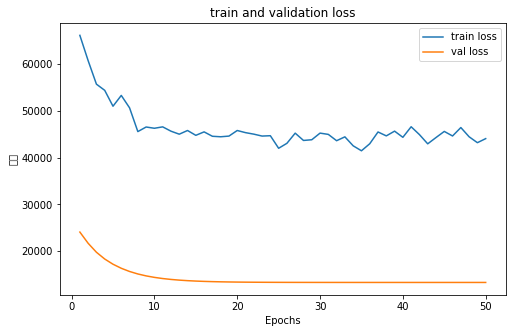

In [34]:
import matplotlib.pyplot as plt

# 假设 history 是模型训练过程的历史记录
# 提取训练损失和验证损失
train_loss = history.history['loss']
val_loss = history.history.get('val_loss', [])  # 如果有验证损失的话

# 创建损失变化图的横坐标，即每个epoch的编号
epochs_range = range(1, len(train_loss) + 1)

# 绘图
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_loss, label='train loss')
if val_loss:  # 如果有验证集损失
    plt.plot(epochs_range, val_loss, label='val loss')

plt.title('train and validation loss')
plt.xlabel('Epochs')
plt.ylabel('损失')
plt.legend()
plt.show()

In [162]:
df_s=pd.read_csv("sperated_tapes.csv",parse_dates=['period'],index_col='period')
df_s=df_s.drop("Unnamed: 0",axis=1)
df_s=df_s.dropna()
# df_s=df_s.sort_values(by='period')
df_s

,max_price,min_price,open_price,close_price
period,,,,
2025-01-02-1,270,249,267,261
2025-01-02-2,269,248,264,266
2025-01-02-3,270,248,269,254
2025-01-02-4,269,247,255,265
2025-01-02-5,267,247,262,261
...,...,...,...,...
2025-07-01-46,113,93,109,110
2025-07-01-47,113,93,109,109
2025-07-01-48,113,93,109,107


In [163]:
values=df_s.values
values=values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
scaled

array([[0.555944  , 0.55714285, 0.5819398 , 0.56      ],
       [0.55244756, 0.55357146, 0.5719063 , 0.5766667 ],
       [0.555944  , 0.55357146, 0.58862877, 0.5366667 ],
       ...,
       [0.006993  , 0.        , 0.05351171, 0.04666668],
       [0.006993  , 0.        , 0.04682273, 0.01666668],
       [0.006993  , 0.        , 0.01672241, 0.04666668]], dtype=float32)

In [164]:
reframed = series_to_supervised(scaled, 1, 1)
reframed.drop(reframed.columns[[4,5,6]],axis=1,inplace=True)
reframed

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var4(t)
1,0.555944,0.557143,0.581940,0.560000,0.576667
2,0.552448,0.553571,0.571906,0.576667,0.536667
3,0.555944,0.553571,0.588629,0.536667,0.573333
4,0.552448,0.550000,0.541806,0.573333,0.560000
5,0.545455,0.550000,0.565217,0.560000,0.553333
...,...,...,...,...,...
6245,0.006993,0.000000,0.050167,0.063333,0.056667
6246,0.006993,0.000000,0.053512,0.056667,0.053333
6247,0.006993,0.000000,0.053512,0.053333,0.046667
6248,0.006993,0.000000,0.053512,0.046667,0.016667


In [256]:
# 划分训练集和测试集
values = reframed.values
l=4000
train = values[0:l]
test = values[l:]
# 划分训练集和测试集的输入和输出
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
#转化为三维数据
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape)
print(test_X.shape, test_y.shape)

(4000, 1, 4) (4000,)
(2249, 1, 4) (2249,)


Epoch 1/50


D:\zzyAnaconda\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 - 1s - 25ms/step - loss: 0.3077 - val_loss: 0.0619
Epoch 2/50
40/40 - 0s - 2ms/step - loss: 0.0857 - val_loss: 0.0500
Epoch 3/50
40/40 - 0s - 2ms/step - loss: 0.0554 - val_loss: 0.0258
Epoch 4/50
40/40 - 0s - 2ms/step - loss: 0.0412 - val_loss: 0.0189
Epoch 5/50
40/40 - 0s - 2ms/step - loss: 0.0328 - val_loss: 0.0182
Epoch 6/50
40/40 - 0s - 2ms/step - loss: 0.0301 - val_loss: 0.0174
Epoch 7/50
40/40 - 0s - 2ms/step - loss: 0.0285 - val_loss: 0.0154
Epoch 8/50
40/40 - 0s - 2ms/step - loss: 0.0276 - val_loss: 0.0142
Epoch 9/50
40/40 - 0s - 2ms/step - loss: 0.0275 - val_loss: 0.0133
Epoch 10/50
40/40 - 0s - 2ms/step - loss: 0.0279 - val_loss: 0.0125
Epoch 11/50
40/40 - 0s - 2ms/step - loss: 0.0265 - val_loss: 0.0119
Epoch 12/50
40/40 - 0s - 2ms/step - loss: 0.0274 - val_loss: 0.0119
Epoch 13/50
40/40 - 0s - 2ms/step - loss: 0.0270 - val_loss: 0.0120
Epoch 14/50
40/40 - 0s - 2ms/step - loss: 0.0268 - val_loss: 0.0121
Epoch 15/50
40/40 - 0s - 2ms/step - loss: 0.0264 - val_loss: 0.0122

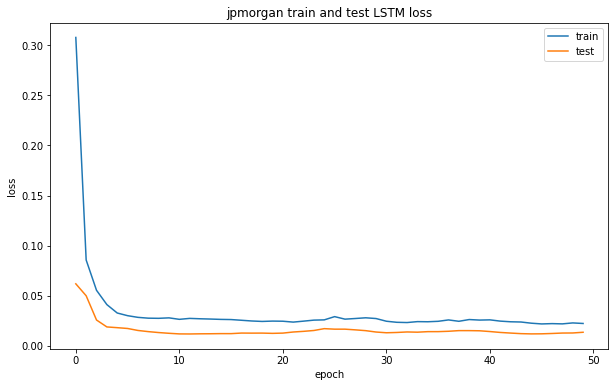

In [262]:
# 搭建LSTM模型
model = Sequential()
model.add(LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.122))
model.add(Dense(1,activation='relu'))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=100, validation_data=(test_X, test_y), verbose=2,shuffle=False)

# 绘制损失图
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('jpmorgan train and test LSTM loss', fontsize='12')
plt.ylabel('loss', fontsize='10')
plt.xlabel('epoch', fontsize='10')
plt.legend()
plt.show()

In [263]:
#模型预测收益率
y_predict = model.predict(test_X)
test_X1 = test_X.reshape((test_X.shape[0], test_X.shape[2]))

71/71 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [264]:
# invert scaling for forecast
#将预测结果按比例反归一化
inv_y_test = np.concatenate((test_X1[:, :3],y_predict), axis=1)
inv_y_test = scaler.inverse_transform(inv_y_test)
inv_y_predict=inv_y_test[:,-1]

# invert scaling for actual
#将真实结果按比例反归一化
test_y = test_y.reshape((len(test_y), 1))
inv_y_train = np.concatenate((test_X1[:, :3],test_y), axis=1)
inv_y_train = scaler.inverse_transform(inv_y_train)
inv_y = inv_y_train[:, -1]
print('反归一化后的预测结果：',inv_y_predict)
print('反归一化后的真实结果：',inv_y)

反归一化后的预测结果： [152.8359   154.0745   155.25142  ... 111.602425 111.2773   109.42343 ]
反归一化后的真实结果： [160. 161. 160. ... 107.  98. 107.]


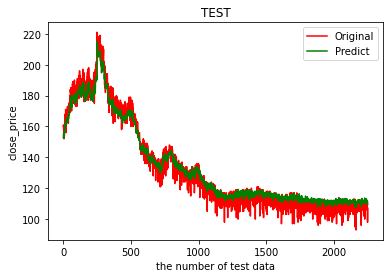

In [265]:
plt.plot(inv_y,color='red',label='Original')
plt.plot(inv_y_predict,color='green',label='Predict')
plt.xlabel('the number of test data')
plt.ylabel('close_price')
plt.title('TEST')
plt.legend()
plt.show()

In [266]:

#回归评价指标
# calculate MSE 均方误差
mse=mean_squared_error(inv_y,inv_y_predict)
# calculate RMSE 均方根误差
rmse = np.sqrt(mean_squared_error(inv_y, inv_y_predict))
#calculate MAE 平均绝对误差
mae=mean_absolute_error(inv_y,inv_y_predict)
#calculate R square
r_square=r2_score(inv_y,inv_y_predict)
print('MSE: %.6f' % mse)
print('RMSE: %.6f' % rmse)
print('MAE: %.6f' % mae)
print('R_square: %.6f' % r_square)

MSE: 27.199343
RMSE: 5.215299
MAE: 4.071338
R_square: 0.969629


In [253]:
import optuna

def objective(trial):
    # 定义超参数的搜索空间
    lstm_units = trial.suggest_int('lstm_units', 20, 100)
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    optimizer = trial.suggest_categorical('optimizer', ['rmsprop', 'adam', 'sgd'])

    # 构建模型（此处使用 LSTM 模型作为示例）
    model = Sequential()
    model.add(LSTM(lstm_units, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mae', optimizer=optimizer)

    # 训练模型
    history = model.fit(train_X, train_y, epochs=100, batch_size=100, validation_data=(test_X, test_y), verbose=0, shuffle=False)

    # 获取验证集上的损失，并将其作为目标值返回
    val_loss = history.history['val_loss'][-1]
    return val_loss


In [254]:
study = optuna.create_study(direction='minimize')  # 如果是最小化目标值，如损失
study.optimize(objective, n_trials=10)  # n_trials 是尝试的次数


[I 2024-03-13 23:13:58,805] A new study created in memory with name: no-name-916e4f62-33a4-4d57-921a-f2ba794703ea
C:\Users\14620\AppData\Local\Temp/ipykernel_8012/2726465199.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
D:\zzyAnaconda\lib\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
[I 2024-03-13 23:14:07,294] Trial 0 finished with value: 0.01987648569047451 and parameters: {'lstm_units': 43, 'dropout_rate': 0.4308831136781465, 'optimizer': 'sgd'}. Best is trial 0 with value: 0.01987648569047451.
[I 2024-03-13 23:14:16,874] Trial 1 finished with value: 0.016134738922

In [255]:
print('Best trial:', study.best_trial.params)
print('Best value:', study.best_trial.value)

Best trial: {'lstm_units': 48, 'dropout_rate': 0.12280897419470854, 'optimizer': 'sgd'}
Best value: 0.011535175144672394
